# Each section can be run on its own

# GBIF

In [3]:
from pygbif import species as species
from pygbif import occurrences as occ

In [4]:
splist = ['Cyanocitta stelleri', 'Junco hyemalis', 'Aix sponsa',
  'Ursus americanus', 'Pinus conorta', 'Poa annuus']
keys = [ species.name_backbone(x)['usageKey'] for x in splist ]

In [5]:
out = [ occ.search(taxonKey = x, limit=0)['count'] for x in keys ]

In [6]:
x = dict(zip(splist, out))
sorted(x.items(), key=lambda z:z[1], reverse=True)

[('Junco hyemalis', 14827936),
 ('Aix sponsa', 6498428),
 ('Cyanocitta stelleri', 2756192),
 ('Poa annuus', 741730),
 ('Pinus conorta', 105934),
 ('Ursus americanus', 53946)]

# SatCLIP

In [7]:
import sys
import os

In [11]:
# clone satclip into a folder, use your own username
satclip_path = "/home/mila/g/<username>/scratch/satclip"

In [12]:
sys.path.append(satclip_path)
sys.path.insert(0, "/home/mila/g/<username>/scratch/satclip/satclip")

In [13]:
from satclip.model import SatCLIP

/network/scratch/g/gregory.bell/COMP-685-Fall-2025/.venv/lib/python3.11/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [14]:
from satclip.location_encoder import LocationEncoder

In [15]:
model = SatCLIP(
    embed_dim=512,
    image_resolution=224, in_channels=13, vision_layers=4, vision_width=768, vision_patch_size=32, # Image encoder
    le_type='sphericalharmonics', pe_type='siren', legendre_polys=10, frequency_num=16, max_radius=360, min_radius=1, harmonics_calculation='analytic'  # Location encoder
)


using vision transformer


In [16]:
import torch

In [17]:
img_batch = torch.randn(32, 13, 224, 224) # Represents a batch of 32 images
loc_batch = torch.randn(32, 2) # Represents the corresponding 32 locations (lon/lat)

In [18]:
with torch.no_grad():
    logits_per_image, logits_per_coord = model(img_batch, loc_batch)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()

# INaturalist

In [19]:
from pyinaturalist import get_observations

In [20]:
observations = get_observations()

INFO:Request:
GET https://api.inaturalist.org/v1/observations
User-Agent: python-requests/2.32.5 pyinaturalist/0.20.2
Accept-Encoding: gzip, deflate
Accept: application/json
Connection: keep-alive



In [21]:
observations.keys()

dict_keys(['total_results', 'page', 'per_page', 'results'])

In [22]:
observations['total_results']

312784440

# eBird

In [1]:
# account api key is needed, may be best to load dataset outside computer node.

# TimesFM

In [1]:
# clone in another folder and install in the uv venv

In [1]:
# pip install transformers>=4.53 torch numpy
import numpy as np
import torch
from torch.nn.functional import normalize
from transformers import TimesFmModelForPrediction

# 1) Load a TimesFM checkpoint (univariate)
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",  # or a newer 2.5 checkpoint if/when available
    dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map="auto",
)

# 2) Example batch of variable-length time series (replace with your data)
series = [
    np.sin(np.linspace(0, 20, 100)),   # length 100
    np.sin(np.linspace(0, 20, 240)),   # length 240
    np.sin(np.linspace(0, 20, 512)),   # length 512
    np.sin(np.linspace(0, 20, 1024)),   # length 1024
]

# Convert to tensors on the model's device
past_values = [torch.tensor(x, dtype=torch.bfloat16, device=model.device) for x in series]

# TimesFM uses a small frequency embedding; if you don't know it, you can set zeros.
# Shape: (batch,)
freq = torch.zeros(len(past_values), dtype=torch.long, device=model.device)

# 3) Forward pass requesting hidden states
with torch.no_grad():
    out = model(
        past_values=past_values,
        freq=freq,
        output_hidden_states=True,   # <— important
        return_dict=True,
    )

# out.last_hidden_state: (batch, seq_len, hidden_size) after internal padding
# We'll mean-pool over the *valid* timesteps for each series, then L2-normalize.

embeddings = []
for i, ts in enumerate(past_values):
    L = ts.shape[0]  # original (unpadded) length
    # slice to valid region, mean-pool over time
    vec = out.last_hidden_state[i, :L, :].float().mean(dim=0)
    embeddings.append(vec)

embeddings = torch.stack(embeddings, dim=0)           # (batch, hidden_size)
embeddings = normalize(embeddings, p=2, dim=1)        # cosine-friendly

print(embeddings.shape)   # e.g., torch.Size([4, 1280]) for the 500M checkpoint

/network/scratch/g/gregory.bell/COMP-685-Fall-2025/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([4, 1280])


# Chronos

In [2]:

import numpy as np
import torch
from torch.nn.functional import normalize
from chronos import ChronosPipeline

# 1) Load a Chronos (T5) checkpoint
pipe = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",           # try base/large for bigger models
    device_map="auto",
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)

# 2) Example batch: variable-length univariate series
rng = np.random.default_rng(0)
series = [
    np.sin(np.linspace(0, 8*np.pi, 120)) + 0.1 * rng.standard_normal(120),
    np.sin(np.linspace(0, 8*np.pi, 200)) + 0.1 * rng.standard_normal(200),
    np.sin(np.linspace(0, 8*np.pi, 350)) + 0.1 * rng.standard_normal(350),
]

# Convert to a list of 1D tensors (no manual padding needed)
batch = [torch.tensor(x, dtype=torch.float32) for x in series]
lengths = [len(x) for x in batch]

# 3) Extract encoder embeddings for the whole batch
#    emb has shape (batch, seq_len, hidden) with internal padding handled for you.
emb, tok_state = pipe.embed(batch)

# 4) Pool to a single fixed-size vector per series (mask out padding)
#    We'll mean-pool over the valid (unpadded) timesteps, then L2-normalize.
pooled = []
for i, L in enumerate(lengths):
    vec = emb[i, :L, :].float().mean(dim=0)   # (hidden,)
    pooled.append(vec)

embeddings = torch.stack(pooled, dim=0)       # (batch, hidden)
embeddings = normalize(embeddings, p=2, dim=1)

print("Per-series embedding shape:", embeddings.shape)   # e.g., torch.Size([3, hidden])


`torch_dtype` is deprecated! Use `dtype` instead!


Per-series embedding shape: torch.Size([3, 512])


# Temperature data from SatCLIP

In [1]:
from urllib import request
import numpy as np
import pandas as pd
import io
import torch


def get_air_temp_data(pred="temp",norm_y=True,norm_x=True):
  '''
  Download and process the Global Air Temperature dataset (more info: https://www.nature.com/articles/sdata2018246)

  Parameters:
  pred = numeric; outcome variable to be returned; choose from ["temp", "prec"]
  norm_y = logical; should outcome be normalized
  norm_min_val = integer; choice of [0,1], setting whether normalization in range[0,1] or [-1,1]

  Return:
  coords = spatial coordinates (lon/lat)
  x = features at location
  y = outcome variable
  '''
  url = 'https://springernature.figshare.com/ndownloader/files/12609182'
  url_open = request.urlopen(url)
  inc = np.array(pd.read_csv(io.StringIO(url_open.read().decode('utf-8'))))
  coords = inc[:,:2]
  if pred=="temp":
    y = inc[:,4].reshape(-1)
    x = inc[:,5]
  else:
    y = inc[:,5].reshape(-1)
    x = inc[:,4]
  if norm_y==True:
    y = y / y.max()
  if norm_x==True:
    x = x / x.max()

  return torch.tensor(coords), torch.tensor(x), torch.tensor(y)

In [2]:
coords, _, y = get_air_temp_data()

In [4]:

df_temp = pd.DataFrame({'lon' : coords[:,0],'lat' : coords[:,1], 'temp' : y}) 

In [11]:
df_temp

,lon,lat,temp
0,7.82,36.83,0.591792
1,3.25,36.72,0.593707
2,5.07,36.72,0.570178
3,7.47,36.47,0.568536
4,6.62,36.28,0.506430
...,...,...,...
3071,-6.22,54.65,0.283447
3072,-6.77,62.02,0.204378
3073,-5.35,36.15,0.572640
3074,-16.90,32.63,0.580575


/tmp/ipykernel_2866157/2052611161.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

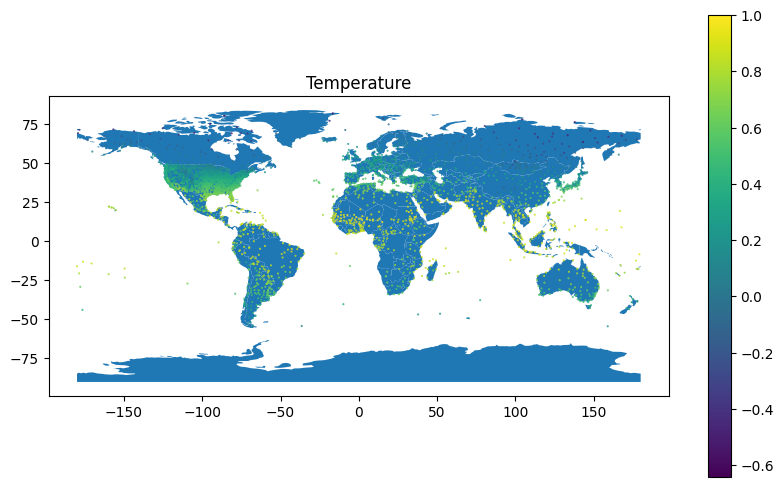

In [10]:
# Let's plot our data. 
# Here we show a map of the world with our locations colored by mean temperatures.
import matplotlib.pyplot as plt
import geopandas as gpd

plt.figure()
gdf = gpd.GeoDataFrame(df_temp, geometry=gpd.points_from_xy(df_temp['lon'], df_temp['lat']))   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), column=df_temp['temp'], markersize=0.2, legend=True)
plt.title(f"Temperature")
plt.show()




# Crop yield yearly data

Iizumi, Toshichika (2019): Global dataset of historical yields v1.2 and v1.3 aligned version [dataset]. PANGAEA, https://doi.org/10.1594/PANGAEA.909132,
Supplement to: Iizumi, Toshichika; Sakai, T (2020): The global dataset of historical yields for major crops 1981–2016. Scientific Data, 7(1), 97, https://doi.org/10.1038/s41597-020-0433-7

https://doi.pangaea.de/10.1594/PANGAEA.909132

In [12]:
!wget https://store.pangaea.de/Publications/IizumiT_2019/gdhy_v1.2_v1.3_20190128.zip

--2025-11-16 17:28:24--  https://store.pangaea.de/Publications/IizumiT_2019/gdhy_v1.2_v1.3_20190128.zip
Resolving store.pangaea.de (store.pangaea.de)... 134.1.2.172
Connecting to store.pangaea.de (store.pangaea.de)|134.1.2.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15989683 (15M) [application/zip]
Saving to: ‘gdhy_v1.2_v1.3_20190128.zip’

gdhy_v1.2_v1.3_2019 100%[===================>]  15.25M  10.9MB/s    in 1.4s    

2025-11-16 17:28:26 (10.9 MB/s) - ‘gdhy_v1.2_v1.3_20190128.zip’ saved [15989683/15989683]



In [13]:
!mv gdhy_v1.2_v1.3_20190128.zip data/gdhy_v1.2_v1.3_20190128.zip

In [14]:
!unzip -q data/gdhy_v1.2_v1.3_20190128.zip -d data/

In [15]:
import xarray as xr
import pandas as pd 
# example year and crop
dataset = xr.open_dataset('data/maize/yield_2016.nc4')
df = dataset.to_dataframe().reset_index()

In [16]:
df

,lat,lon,var
0,-89.75,0.25,NaN
1,-89.75,0.75,NaN
2,-89.75,1.25,NaN
3,-89.75,1.75,NaN
4,-89.75,2.25,NaN
...,...,...,...
259195,89.75,357.75,NaN
259196,89.75,358.25,NaN
259197,89.75,358.75,NaN
259198,89.75,359.25,NaN


In [17]:
# change to >-180 to 180 instead of >0 to 360 longitude
df['lon'] = [i if i <= 180 else -360 + i for i in df['lon']]

/tmp/ipykernel_2866157/1267242757.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

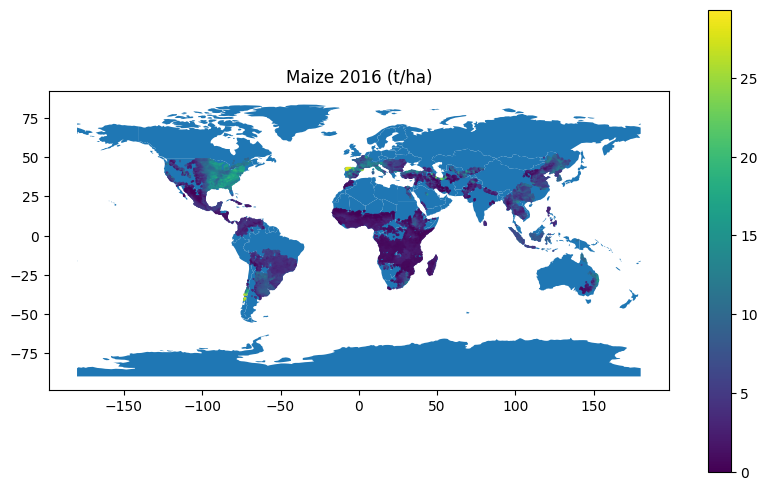

In [19]:
import matplotlib.pyplot as plt
import geopandas as gpd

plt.figure()
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), column=df['var'], markersize=0.2, legend=True)
plt.title(f"Maize 2016 (t/ha)")
plt.show()

# GlobalCropYield5min: A global gridded annual major crops yield dataset at 5-minute resolution during 1982-2015
Published: 17 March 2025 | Version 4 | DOI:10.17632/hg8wzgx4yp.4 Contributors:Juan Cao
,Zhao Zhang,Xiangzhong Luo,jialu Xu,Yuchuan Luo,Jun Xie,Jichong Han,F Tao

In [21]:
!wget -P data/GlobalCropYield5min1982_2015_V4.rar https://data.mendeley.com/public-files/datasets/hg8wzgx4yp/files/75ae8d3f-85d1-484f-bd82-5f6c35c2e252/file_downloaded

--2025-11-16 18:33:15--  https://data.mendeley.com/public-files/datasets/hg8wzgx4yp/files/75ae8d3f-85d1-484f-bd82-5f6c35c2e252/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/ba02f76a-bfbf-4c32-b776-fa0fea168666 [following]
--2025-11-16 18:33:16--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/ba02f76a-bfbf-4c32-b776-fa0fea168666
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 3.5.71.92, 3.5.69.253, 3.5.66.139, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|3.5.71.92|:443... connec

In [22]:
!unrar x -idq ./data/GlobalCropYield5min1982_2015_V4.rar ./data

In [23]:
import rasterio
# example data
src = rasterio.open('data/GlobalCropYield5min1982_2015_V4/GlobalCropYield5min/Maize/Maize1982.tif')

In [24]:
array = src.read(1)

In [25]:
# yield values
array.shape

(1112, 3085)

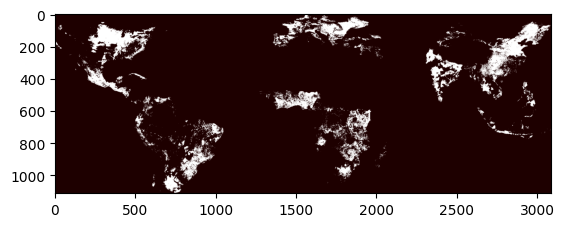

In [26]:
from matplotlib import pyplot
pyplot.imshow(array, cmap='pink')

pyplot.show()

In [28]:
# left edge
print(src.bounds[0])
# bottom edge
print(src.bounds[1])
# right edge
print(src.bounds[2])
# top edge
print(src.bounds[3])

-122.375
-38.95833333333303
134.7083333323106
53.70833333296497


In [29]:
# coords
src.xy(0,2)

(-122.1666666666675, 53.66666666629847)

In [30]:
# there may be a quicker way to get coords and vals

lats = []
lons = []
vals = []
for row in range(array.shape[0]):
    for col in range(array.shape[1]):
        lon, lat = src.xy(row, col)
        lats.append(lat)
        lons.append(lon)
        vals.append(array[row, col])
        

In [32]:
df = pd.DataFrame({'lat':lats, 'lon':lons, 'yield': [i if i > 0 else np.nan for i in vals]})
df

,lat,lon,yield
0,53.666667,-122.333333,NaN
1,53.666667,-122.250000,NaN
2,53.666667,-122.166667,NaN
3,53.666667,-122.083333,NaN
4,53.666667,-122.000000,NaN
...,...,...,...
3430515,-38.916667,134.333333,NaN
3430516,-38.916667,134.416667,NaN
3430517,-38.916667,134.500000,NaN
3430518,-38.916667,134.583333,NaN


/tmp/ipykernel_2866157/3938860694.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Figure size 640x480 with 0 Axes>

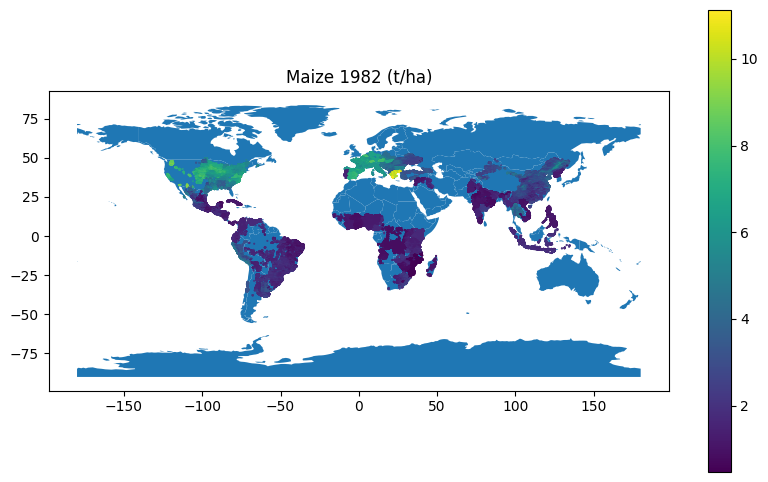

In [33]:
import matplotlib.pyplot as plt
import geopandas as gpd

plt.figure()
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf.plot(ax=world.plot(figsize=(10, 6)), column=df['yield'], markersize=0.2, legend=True)
plt.title(f"Maize 1982 (t/ha)")
plt.show()